<a href="https://colab.research.google.com/github/ameyas1/LSTM_Autoencoder_Anomaly_Detection/blob/master/AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


In [0]:
df = pd.read_csv('/content/S&P_500_Index_Data.csv', parse_dates=['date'])
# df = pd.read_csv('/content/icicibank.csv', parse_dates=['date'])
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [0]:
df.shape

(8192, 2)

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.close,
                    mode='lines',
                    name='close'))
fig.update_layout(showlegend=True)
fig.show()

In [0]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:]
print(train.shape, test.shape)

(7372, 2) (820, 2)


In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [0]:
time_steps = 30

X_train, y_train = create_dataset(train[['close']], train.close, time_steps)
X_test, y_test = create_dataset(test[['close']], test.close, time_steps)



In [0]:
X_train.shape

(7342, 30, 1)

In [0]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Bidirectional, SpatialDropout2D

model = Sequential([
    Bidirectional(LSTM(128, kernel_regularizer= tf.keras.regularizers.l2(0.001)), input_shape=(timesteps, num_features)),
    RepeatVector(timesteps),
    SpatialDropout1D(0.1),
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer= tf.keras.regularizers.l2(0.001))),
    SpatialDropout1D(0.1),
    TimeDistributed(Dense(num_features))                 
])



In [0]:
model.compile(loss='mae', optimizer='adam')


In [0]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_21 (Bidirectio (None, 256)               133120    
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 30, 256)           0         
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 30, 256)           0         
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 30, 256)           394240    
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 30, 256)           0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 30, 1)             257       
Total params: 527,617
Trainable params: 527,617
Non-trainable params: 0
_______________________________________________

In [0]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')
chkpt = tf.keras.callbacks.ModelCheckpoint("anamoly.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.15,
    callbacks = [es,chkpt],
    shuffle=True
)

Epoch 1/100
191/195 [============================>.] - ETA: 0s - loss: 0.2693
Epoch 00001: val_loss improved from inf to 0.13700, saving model to anamoly.h5
195/195 [==============================] - 3s 17ms/step - loss: 0.2662 - val_loss: 0.1370
Epoch 2/100
192/195 [============================>.] - ETA: 0s - loss: 0.0958
Epoch 00002: val_loss improved from 0.13700 to 0.08902, saving model to anamoly.h5
195/195 [==============================] - 2s 11ms/step - loss: 0.0958 - val_loss: 0.0890
Epoch 3/100
194/195 [============================>.] - ETA: 0s - loss: 0.0725
Epoch 00003: val_loss improved from 0.08902 to 0.06130, saving model to anamoly.h5
195/195 [==============================] - 2s 11ms/step - loss: 0.0725 - val_loss: 0.0613
Epoch 4/100
191/195 [============================>.] - ETA: 0s - loss: 0.0620
Epoch 00004: val_loss improved from 0.06130 to 0.05700, saving model to anamoly.h5
195/195 [==============================] - 2s 11ms/step - loss: 0.0618 - val_loss: 0.0570


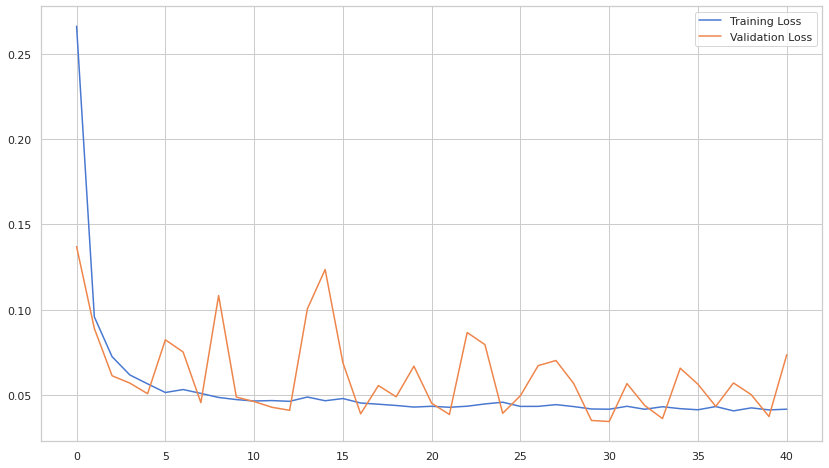

In [0]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [0]:
model.load_weights('/content/anamoly.h5')

In [0]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [0]:
train_mae_loss.head()

,Error
0,0.024536
1,0.024963
2,0.026298
3,0.027814
4,0.026959


In [0]:
np.max(train_mae_loss['Error'].values)

0.49934329511585573

In [0]:
model.evaluate(X_test, y_test)

25/25 [==============================] - 0s 5ms/step - loss: 0.0655


0.06553351134061813

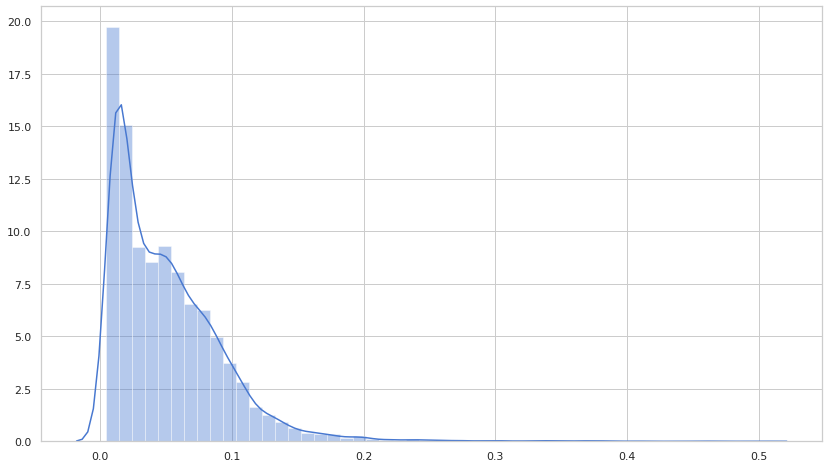

In [0]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [0]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

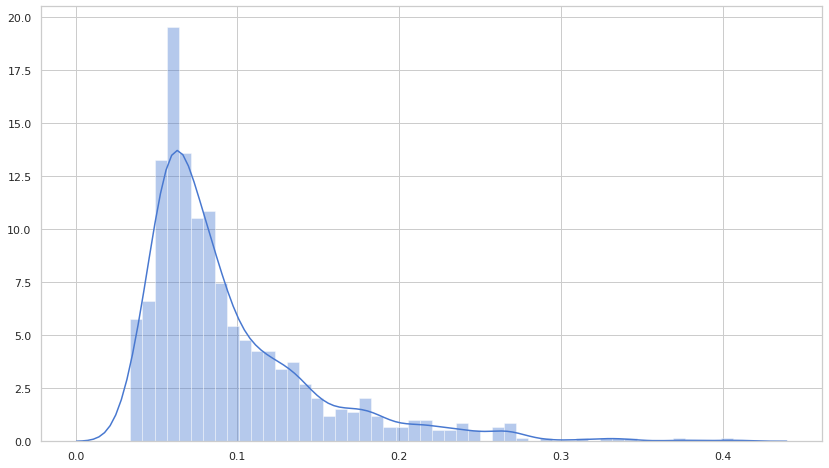

In [0]:
sns.distplot(test_mae_loss, bins=50, kde=True);

In [0]:
THRESHOLD = .25

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [0]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly
7474,2015-08-25,1.938568,0.340397,0.25,True
7475,2015-08-26,2.090148,0.406289,0.25,True
7476,2015-08-27,2.188186,0.325431,0.25,True
7480,2015-09-02,2.107510,0.268035,0.25,True
7481,2015-09-03,2.112230,0.265337,0.25,True


In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=scaler.inverse_transform(test[time_steps:].close),
                    mode='lines',
                    name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close),
                    mode='markers',
                    name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()